In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install torch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Importing the Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 17.09 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Some common imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

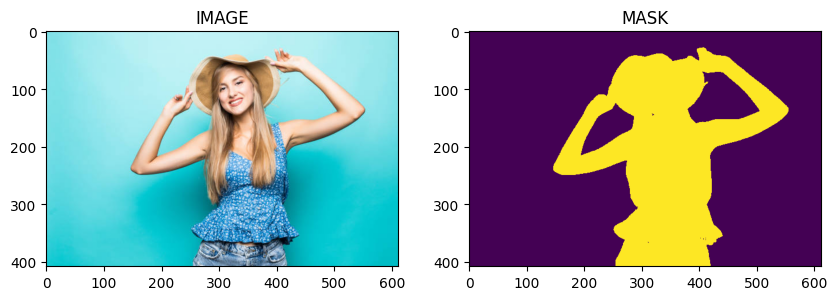

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

Augmentation Functions

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ], is_check_shapes=False)

Creating custom dataset


In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask)  / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f'Length of trainset: {len(trainset)}')
print(f'Length of validset: {len(validset)}')

Length of trainset: 232
Length of validset: 58


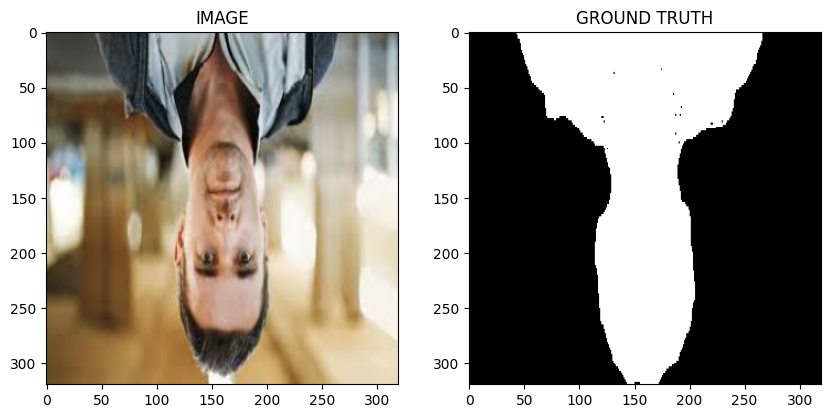

In [ ]:
idx = 32

image, mask = trainset[idx]
helper.show_image(image, mask)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f'Length of trainloader: {len(trainloader)}')
print(f'Length of validloader: {len(validloader)}')

Length of trainloader: 15
Length of validloader: 4


In [ ]:
# for image, mask in trainloader:
#   break
# print(f'Image shape: {image.shape}')
# print(f'Mask shape: {mask.shape}')

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits


In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 78.0MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.inf
for epoch in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    #best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pt')
    print('Saved Best Model!')
    best_valid_loss = valid_loss
  print(f'Epoch: {epoch+1}')
  print(f'Train Loss: {train_loss:.4f}')
  print(f'Valid Loss: {valid_loss:.4f}')

100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Saved Best Model!
Epoch: 1
Train Loss: 0.7408
Valid Loss: 1.7617


100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


Saved Best Model!
Epoch: 2
Train Loss: 0.3856
Valid Loss: 1.7324


100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Saved Best Model!
Epoch: 3
Train Loss: 0.3197
Valid Loss: 0.3763


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Epoch: 4
Train Loss: 0.2826
Valid Loss: 0.3790


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


Saved Best Model!
Epoch: 5
Train Loss: 0.2387
Valid Loss: 0.2538


100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Saved Best Model!
Epoch: 6
Train Loss: 0.2134
Valid Loss: 0.2309


100%|██████████| 4/4 [00:00<00:00,  6.24it/s]


Saved Best Model!
Epoch: 7
Train Loss: 0.1856
Valid Loss: 0.2256


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch: 8
Train Loss: 0.1799
Valid Loss: 0.2593


100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


Saved Best Model!
Epoch: 9
Train Loss: 0.1756
Valid Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Saved Best Model!
Epoch: 10
Train Loss: 0.1769
Valid Loss: 0.2141


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch: 11
Train Loss: 0.1615
Valid Loss: 0.2281


100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


Epoch: 12
Train Loss: 0.1380
Valid Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Saved Best Model!
Epoch: 13
Train Loss: 0.1469
Valid Loss: 0.1614


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


Epoch: 14
Train Loss: 0.1428
Valid Loss: 0.2532


100%|██████████| 4/4 [00:00<00:00,  6.18it/s]


Epoch: 15
Train Loss: 0.1892
Valid Loss: 0.2428


100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


Epoch: 16
Train Loss: 0.1496
Valid Loss: 0.2058


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch: 17
Train Loss: 0.1688
Valid Loss: 0.1670


100%|██████████| 4/4 [00:00<00:00,  6.21it/s]


Epoch: 18
Train Loss: 0.1673
Valid Loss: 0.1969


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch: 19
Train Loss: 0.1334
Valid Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Epoch: 20
Train Loss: 0.1143
Valid Loss: 0.1751


100%|██████████| 4/4 [00:00<00:00,  6.22it/s]


Epoch: 21
Train Loss: 0.1265
Valid Loss: 0.1736


100%|██████████| 4/4 [00:00<00:00,  6.24it/s]


Epoch: 22
Train Loss: 0.1061
Valid Loss: 0.1687


100%|██████████| 4/4 [00:00<00:00,  6.19it/s]


Saved Best Model!
Epoch: 23
Train Loss: 0.0956
Valid Loss: 0.1557


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


Epoch: 24
Train Loss: 0.1194
Valid Loss: 0.1856


100%|██████████| 4/4 [00:00<00:00,  6.16it/s]

Epoch: 25
Train Loss: 0.1307
Valid Loss: 0.2377


In [ ]:
idx = 20
model.load_state_dict(torch.load('best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
logits_mask = torch.sigmoid(logits_mask)
pred_mask = (logits_mask > 0.5).float()

<ipython-input-27-d356014889c0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


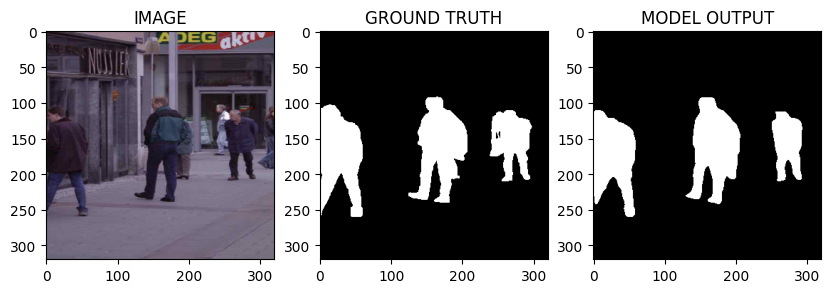

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))